In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
import scipy.stats as st
%matplotlib inline

In [23]:
import datetime as dt
a = dt.datetime(2012,8,21,23,59,59) #August 21 2017
b = dt.datetime(2018,1,8,23,59,59) #Jan 08 2018
total_time = (b-a).total_seconds()
total_time

169862400.0

In [24]:
data=pd.read_csv("profiles.csv")
originial_data= data[['total_time_played']]

df = originial_data.replace('NaN', np.nan)
df = df.dropna()
print('original len after removing nan:', len(df))

df_removed = df.loc[df['total_time_played'] > total_time]
df = df.loc[df['total_time_played'] <= total_time]
len(df_removed), len(df), len(df_removed) + len(df)

original len after removing nan: 75927


(36, 75891, 75927)

### The original data distribution 

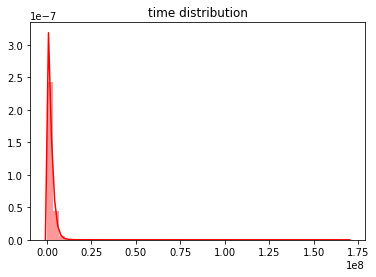

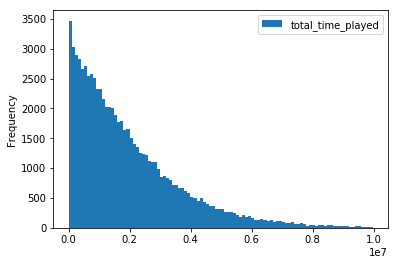

In [25]:
sns.distplot(df, color='red',bins=50)
plt.title("time distribution")

threshold = 10 ** 7
ax = df[df['total_time_played'] < threshold].plot(kind='hist', bins=100)
plt.show()


### Rank Frequency Plot

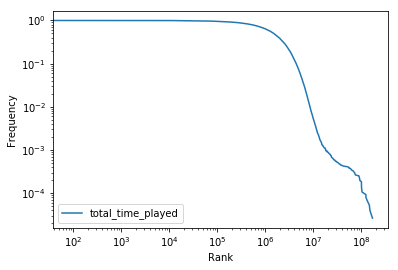

In [26]:
df_freq = df.sort_values(by='total_time_played').reset_index(drop=True)
#rankings the sorted values
df_freq = df_freq.reset_index()
#complementary cumalative freq
df_freq['y_k'] = (1.0 - df_freq['index'] / (df_freq.shape[0] + 1))
#plot
df_freq.plot(kind='line', x='total_time_played', y='y_k', logx=True, logy=True)
plt.xlabel('Rank')
plt.ylabel('Frequency')
# plt.title('Rank-Frequency')
plt.legend(['total_time_played'])
plt.show()

# The first four moments

In [27]:
max(df['total_time_played']), min(df['total_time_played'])

(169408144.0, 0.0)

In [28]:
def own_mean(df):
    return sum(df['total_time_played'])/len(df)

def own_variance(df, mean):
    s = sum([(xi - mean)**2 for xi in df['total_time_played']])
    return s/len(df)
own_variance(df, own_mean(df))

7242632689787.154

In [29]:
(1698624000 - own_mean(df))**2 #< 7242632689787

2.878430484167072e+18

In [30]:
from scipy.stats import kurtosis
from scipy.stats import skew

mean_new=np.mean(df)
var_new=np.var(df)
skew_new=skew(df)
kur_new=kurtosis(df)

print("The mean is %f,variance is %f, skew is %f and kurtosis is %f"%(mean_new,var_new,skew_new,kur_new))


The mean is 2030211.208154,variance is 7242632689787.143555, skew is 21.226506 and kurtosis is 903.490105


In [31]:
7,242,632,689,787
7,242,632,689,787
7,242,632,689,787

(7, 242, 632, 689, 787)

# Maximum likelihood to Check against 7 distributions

In [95]:
distributions =  [st.laplace, st.norm, st.expon, st.dweibull, st.invweibull, st.lognorm, st.uniform]

mles = []

for distribution in distributions:
    pars = distribution.fit(df.total_time_played)
    mle = distribution.nnlf(pars, df.total_time_played)
    mles.append(mle)

results = [(distribution.name, mle) for distribution, mle in zip(distributions, mles)]

for dist in sorted(zip(distributions, mles), key=lambda d: d[1]):
    print(dist)
best_fit = sorted(zip(distributions, mles), key=lambda d: d[1])[0]
print('Best fit reached using {}, MLE value: {}'.format(best_fit[0].name, best_fit[1]))

print([mod[0].name for mod in sorted(zip(distributions, mles), key=lambda d: d[1])])

/Users/dingding/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/dingding/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(<scipy.stats._continuous_distns.expon_gen object at 0x180b4e56d8>, 1178105.3516739777)
(<scipy.stats._continuous_distns.lognorm_gen object at 0x180b528a20>, 1179841.4075585718)
(<scipy.stats._continuous_distns.dweibull_gen object at 0x180b4e5438>, 1199842.9106177024)
(<scipy.stats._continuous_distns.laplace_gen object at 0x180b523c88>, 1199847.2682368422)
(<scipy.stats._continuous_distns.norm_gen object at 0x180b469e80>, 1231289.0881243206)
(<scipy.stats._continuous_distns.invweibull_gen object at 0x180b5231d0>, 1355029.8796182945)
(<scipy.stats._continuous_distns.uniform_gen object at 0x180b557358>, 1437969.1193005815)
Best fit reached using expon, MLE value: 1178105.3516739777
['expon', 'lognorm', 'dweibull', 'laplace', 'norm', 'invweibull', 'uniform']


# Choose top distribution: expon

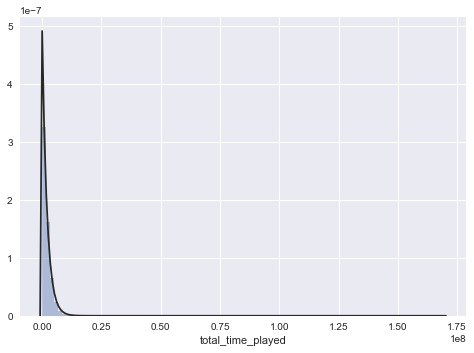

In [96]:
from scipy.stats import expon
ax = sns.distplot(df["total_time_played"], fit=expon, kde=False, bins=100)
ax
plt.show()

# Test and validation

## Find the clipping point between the body and the tail using KS test

In [38]:
clipped_data = data_sorted[:-139]
    
params = st.expon.fit(clipped_data)
kst = st.kstest(clipped_data, 'expon', params)
kst    

KstestResult(statistic=0.022932740827001696, pvalue=4.9831669089918741e-35)

In [60]:
timeplayed = np.flip(np.sort(df['total_time_played']), axis=0)
data_sorted = np.sort(timeplayed )

ks_values = []
for clip_count in range(1, 10000):
    clipped_data = data_sorted[:-clip_count]
    
    params = st.expon.fit(clipped_data)
    kst = st.kstest(clipped_data, 'expon', params)
    
    ks_values.append((clip_count, kst))
        
    if clip_count % 100 == 0:
        print('Finished iteration %i, %s' %(clip_count, kst))

Finished iteration 100, KstestResult(statistic=0.99986805232778886, pvalue=0.0)
Finished iteration 200, KstestResult(statistic=0.98952778662180552, pvalue=0.0)
Finished iteration 300, KstestResult(statistic=0.99837277216740883, pvalue=0.0)
Finished iteration 400, KstestResult(statistic=0.99949169335747978, pvalue=0.0)
Finished iteration 500, KstestResult(statistic=1.0, pvalue=0.0)
Finished iteration 600, KstestResult(statistic=0.98831618217610651, pvalue=0.0)
Finished iteration 700, KstestResult(statistic=0.96049612251200089, pvalue=0.0)
Finished iteration 800, KstestResult(statistic=0.031479695749118408, pvalue=4.6419511769536572e-65)
Finished iteration 900, KstestResult(statistic=1.0, pvalue=0.0)
Finished iteration 1000, KstestResult(statistic=0.98032681350919693, pvalue=0.0)
Finished iteration 1100, KstestResult(statistic=0.98740252491602098, pvalue=0.0)
Finished iteration 1200, KstestResult(statistic=0.79476396530889792, pvalue=0.0)
Finished iteration 1300, KstestResult(statistic=0

Finished iteration 9400, KstestResult(statistic=0.8318148106411889, pvalue=0.0)
Finished iteration 9500, KstestResult(statistic=0.082397516360293632, pvalue=0.0)
Finished iteration 9600, KstestResult(statistic=0.08268449561533292, pvalue=0.0)
Finished iteration 9700, KstestResult(statistic=0.082967625563975023, pvalue=0.0)
Finished iteration 9800, KstestResult(statistic=0.82773780361588434, pvalue=0.0)
Finished iteration 9900, KstestResult(statistic=0.083527879932364213, pvalue=0.0)


In [97]:
ks_min = sorted(ks_values, key=lambda x: x[1].statistic)[0]
print('KS minimum: %i, %f' %(ks_min[0], ks_min[1].statistic))

KS minimum: 139, 0.022933


# Plot distributions for body and tail

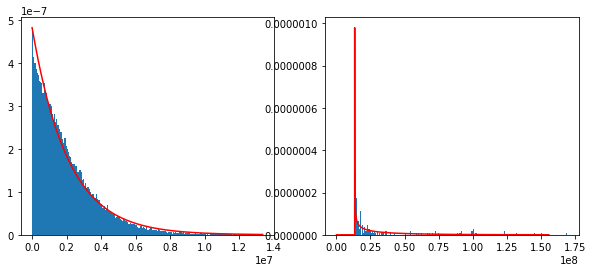

In [33]:
clip_point = 139
timeplayed = np.flip(np.sort(df['total_time_played']), axis=0)
data = timeplayed[clip_point:]

# Setup plot
fig = plt.figure(1, figsize=(10,4))

# Plot body
ax = fig.add_subplot(1, 2, 1, label='plot5')

# Plot histogram
hist, bin_edges = np.histogram(data, bins=200)
plt.hist(data, bins=bin_edges, normed=True)

# Plot exponential curve
params = st.expon.fit(data)

x_axis = np.linspace(min(data), max(data), 10000)
y_axis = st.expon.pdf(x_axis, *params)
plt.plot(x_axis, y_axis, color='red')

# Plot tail
ax = fig.add_subplot(1, 2, 2, label='plot6')
data2= timeplayed[:clip_point]

# Plot histogram
hist, bin_edges = np.histogram(data2, bins=200)
plt.hist(data2, bins=bin_edges, normed=True)

# Plot chi^2 curve
params = st.chi2.fit(data2)

x_axis = np.linspace(min(data2), max(data2), 10000)
y_axis = st.chi2.pdf(x_axis - min(data2), *params)
plt.plot(x_axis - min(data2), y_axis, color='red')

plt.show()

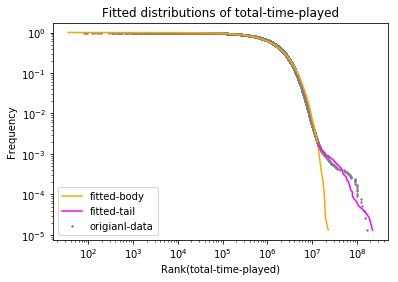

In [36]:
data_sorted = np.sort(timeplayed)
rank = np.flip(np.arange(1, len(data_sorted) + 1), axis=0) / (len(data_sorted) + 1)

# Setup plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, label='plot6')

# Plot points
plt.scatter(data_sorted, rank, color='gray', s=2)

# Plot exponential
params = st.expon.fit(data_sorted)
x_axis = np.sort(st.expon.rvs(*params, len(rank)))

ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(x_axis, rank, color='orange')

# Plot tail
clip_start = 139

lin_data = data_sorted[-clip_start:]
lin_rank = rank[-clip_start:]

params =st.chi2.fit(lin_data)
x_axis = np.sort(st.chi2.rvs(*params, len(lin_rank)))

plt.plot(x_axis, lin_rank, color='fuchsia')
plt.xlabel('Rank(total-time-played)')
plt.ylabel('Frequency')
plt.title('Fitted distributions of total-time-played')

plt.legend(['fitted-body', 'fitted-tail','origianl-data'])
plt.show()